#### Imports

In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torchvision.models as models
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [3]:
# import warnings
# warnings.filterwarnings("ignore")

In [4]:
main_path = "Covid19-dataset"

os.listdir(main_path)

['test', 'train']

### Implement required classes

In [4]:
class OneHotImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=3).float()
        return image, one_hot_label

In [5]:
def getDataLoaders(data_dir, batch_size=16, val_split=0.2):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = OneHotImageFolder(root=f"{data_dir}/train", transform=transform)

    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    test_dataset = OneHotImageFolder(root=f"{data_dir}/test", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [6]:
def visualizeSamples(data_loader, class_names, num_samples=7):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:num_samples]
    labels = labels[:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(class_names[torch.argmax(labels[i]).item()])
    plt.show()

### Check the data

In [7]:
train_loader, val_loader, test_loader = getDataLoaders(main_path)

Training samples: 201
Validation samples: 50
Test samples: 66


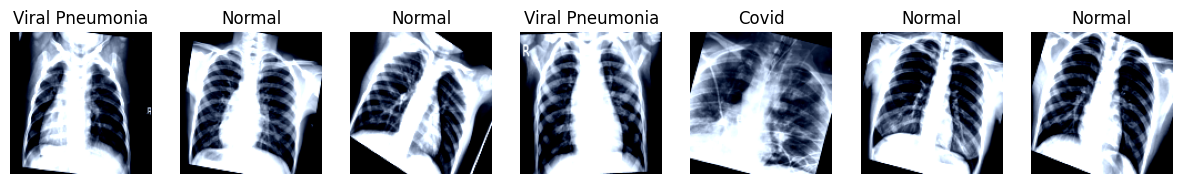

In [9]:
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

class_names = train_loader.dataset.dataset.classes
visualizeSamples(train_loader, class_names)

In [10]:
# Check data shape


# for batch_images, batch_class in train_loader:
#     print(batch_class)
#     print(batch_images.shape, batch_class.shape)

### CNN implementation

In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5) # dropout to enhance result
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv6(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv7(x))
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.dropout(x) # dropout implementation
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Train my model

In [12]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, weight_decay=1e-5, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # L2-regularization

    best_val_acc = 0.0
    best_epoch = 0
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        epoch_train_losses.append(running_loss / len(train_loader))
        epoch_train_accuracies.append(train_acc)

        val_acc, val_loss = evaluate_model(model, val_loader, device)
        epoch_val_losses.append(val_loss)
        epoch_val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Val Loss: {val_loss:.4f}, "
              f"Time: {time.time() - start_time:.2f}s")

    plot_metrics(epoch_train_losses, epoch_val_losses, epoch_train_accuracies, epoch_val_accuracies)

    return model

In [13]:
def evaluate_model(model, val_loader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_loss = running_loss / len(val_loader)

    return val_acc, val_loss

In [14]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Train and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [15]:
def load_best_model(model, device='cpu'):
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    model = model.to(device)
    
    return model

In [16]:
def test_model(model, test_loader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    all_preds = []
    all_labels = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    test_loss = running_loss / len(test_loader)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

Epoch [1/10], Loss: 1.1081, Train Acc: 26.87%, Val Acc: 28.00%, Val Loss: 1.0921, Time: 22.00s
Epoch [2/10], Loss: 1.0970, Train Acc: 35.32%, Val Acc: 50.00%, Val Loss: 1.0601, Time: 21.78s
Epoch [3/10], Loss: 1.0820, Train Acc: 42.79%, Val Acc: 50.00%, Val Loss: 0.9976, Time: 21.47s
Epoch [4/10], Loss: 1.0982, Train Acc: 42.79%, Val Acc: 50.00%, Val Loss: 0.5515, Time: 21.02s
Epoch [5/10], Loss: 1.0222, Train Acc: 44.28%, Val Acc: 50.00%, Val Loss: 0.9982, Time: 21.24s
Epoch [6/10], Loss: 0.9284, Train Acc: 47.26%, Val Acc: 48.00%, Val Loss: 0.8257, Time: 21.41s
Epoch [7/10], Loss: 0.8112, Train Acc: 57.71%, Val Acc: 62.00%, Val Loss: 0.5593, Time: 21.35s
Epoch [8/10], Loss: 0.7083, Train Acc: 63.18%, Val Acc: 64.00%, Val Loss: 0.4390, Time: 21.42s
Epoch [9/10], Loss: 0.5776, Train Acc: 77.11%, Val Acc: 66.00%, Val Loss: 0.5489, Time: 21.97s
Epoch [10/10], Loss: 0.6930, Train Acc: 64.18%, Val Acc: 68.00%, Val Loss: 0.4825, Time: 21.24s


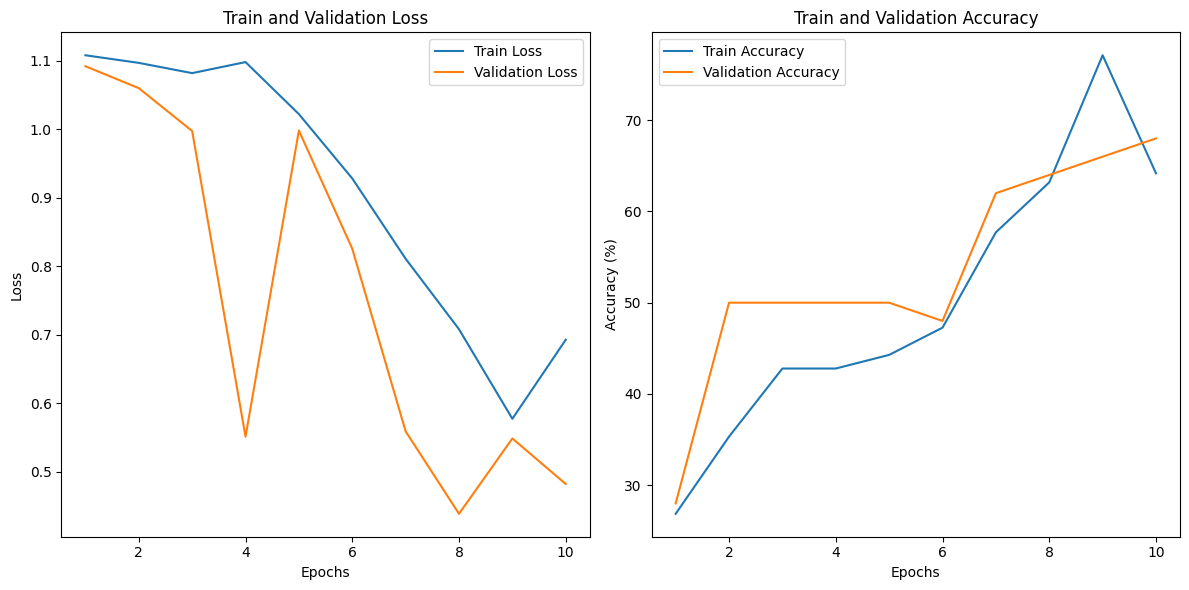

In [17]:
my_cnn = CNN(num_classes=3)
trained_model = train_model(my_cnn, train_loader, val_loader, num_epochs=10, learning_rate=0.001, weight_decay=1e-5, device='cpu')

### Print metrics of my implementation of CNN

In [19]:
best_model = load_best_model(my_cnn, device='cpu')
test_model(best_model, test_loader, device='cpu')

Test Loss: 0.8563
Test Accuracy: 59.09%
Precision: 0.5408
Recall: 0.5909
F1 Score: 0.5215


### Import pretrained models (ResNet & EfficientNet) and train them

In [ ]:
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 1)
resnet_optimizer = optim.Adam(resnet.parameters(), lr=0.001, weight_decay=1e-5)

In [20]:
resnet = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")

RuntimeError: It looks like there is no internet connection and the repo could not be found in the cache (/root/.cache/torch/hub)

In [ ]:
def train_imported_model(model, optimizer, train_loader, val_loader, criterion, num_epochs=25):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().view(-1, 1))
                val_loss += loss.item()

        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')

In [ ]:
# Train ResNet
train_model(resnet, resnet_optimizer, train_loader, val_loader, criterion)


In [ ]:
# Train EfficientNet
train_model(efficientnet, efficientnet_optimizer, train_loader, val_loader, criterion)